# Загружаем датасет, заполняем пропуски в некоторых столбцах константами и делим датасет на тренировочный и валидационный

In [1]:
!pip install catboost

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import math
import numpy as np
import warnings
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error
warnings.filterwarnings('ignore')

In [4]:
source = pd.read_csv('/content/drive/MyDrive/train.csv', usecols=['has_accidents', 'isCab', 'trim_name', 'make_name', 'model_name', 'year', 'horsepower', 'engine_displacement', 'highway_fuel_economy','price', 'vin', 'mileage'])

In [5]:
source = source.drop_duplicates(subset = 'vin', keep = 'first')

In [6]:
source['has_accidents'].fillna(value = 'Unknown', inplace = True)
source['isCab'].fillna(value = 'Unknown', inplace = True)
hfe_val = source['highway_fuel_economy'].median()
source['highway_fuel_economy'].fillna(value = hfe_val, inplace = True)

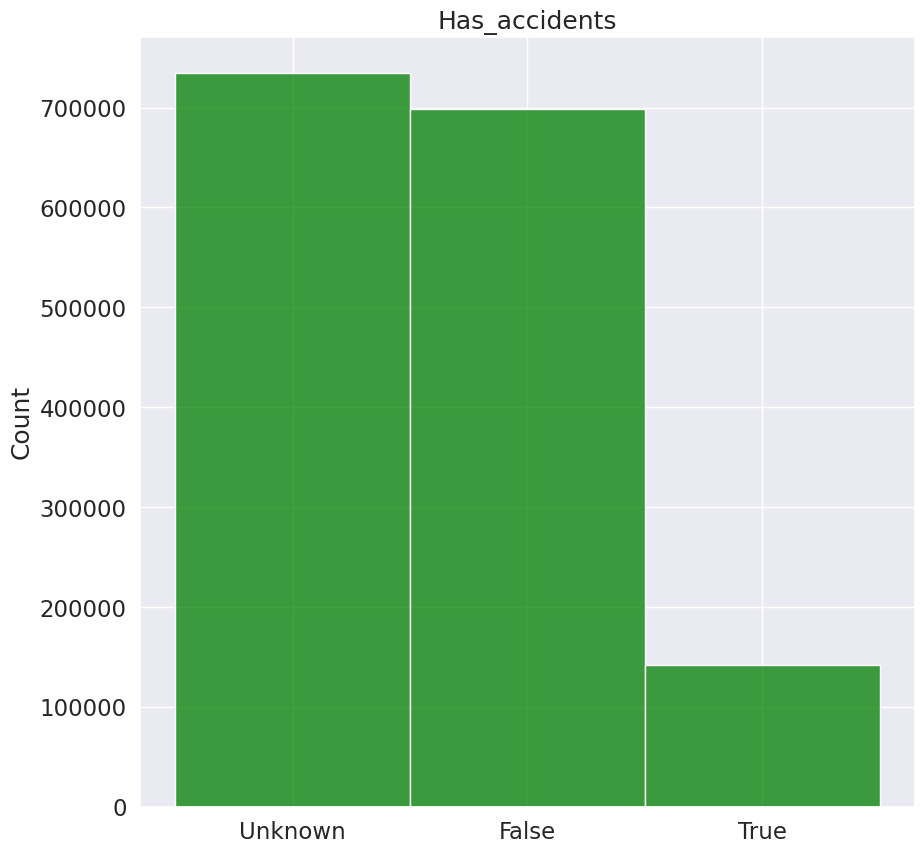

In [7]:
sns.set(
    rc = {  # параметры графика
        'figure.figsize': (10, 10),  # (ширина, высота)
    },
    font_scale=1.5,  # размер шрифта
)
fig, ax = plt.subplots()
sns.histplot(source.has_accidents.astype(str), bins = 100, color = 'green')
plt.title('Has_accidents')
plt.xlabel('')
plt.show()

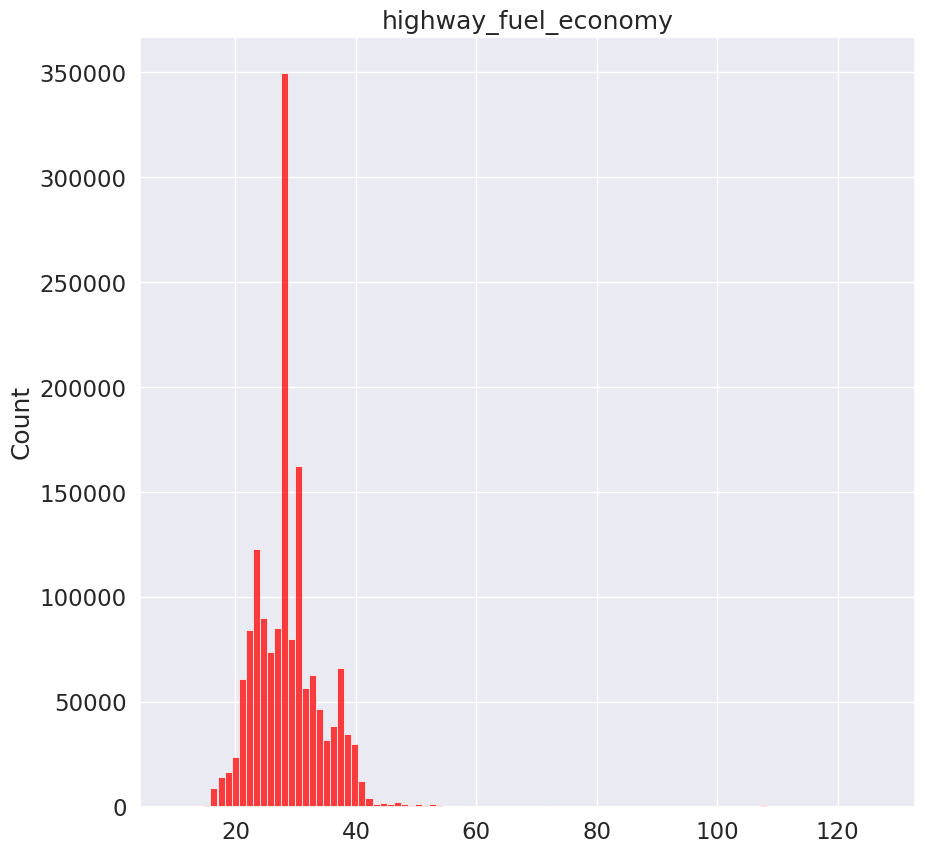

In [8]:
fig, ax = plt.subplots()
sns.histplot(source.highway_fuel_economy, bins = 100, color = 'red')
plt.title('highway_fuel_economy')
plt.xlabel('')
plt.show()

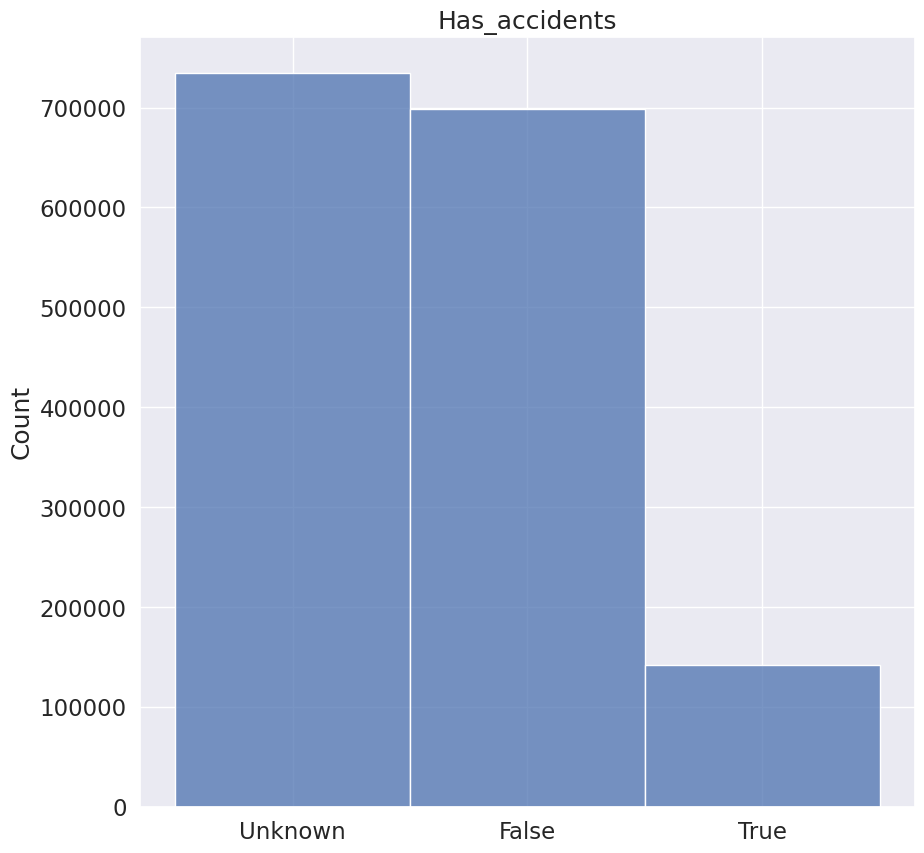

In [9]:
fig, ax = plt.subplots()
sns.histplot(source.has_accidents.astype(str), bins = 100)
plt.title('Has_accidents')
plt.xlabel('')
plt.show()

In [10]:
source.year = source['year'].apply(lambda x: datetime.now().year - x)

In [11]:
train, unused, valid = \
              np.split(source.sample(frac=1, random_state=42),
                       [int(.8*len(source)), int(.8*len(source))])

In [12]:
train = train.reset_index(drop=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259868 entries, 0 to 1259867
Data columns (total 12 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   vin                   1259868 non-null  object 
 1   engine_displacement   1190197 non-null  float64
 2   has_accidents         1259868 non-null  object 
 3   highway_fuel_economy  1259868 non-null  float64
 4   horsepower            1190197 non-null  float64
 5   isCab                 1259868 non-null  object 
 6   make_name             1259868 non-null  object 
 7   mileage               1197796 non-null  float64
 8   model_name            1259868 non-null  object 
 9   price                 1259868 non-null  float64
 10  trim_name             1211594 non-null  object 
 11  year                  1259868 non-null  int64  
dtypes: float64(5), int64(1), object(6)
memory usage: 115.3+ MB


In [13]:
valid = valid.reset_index(drop=True)
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314967 entries, 0 to 314966
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   vin                   314967 non-null  object 
 1   engine_displacement   297350 non-null  float64
 2   has_accidents         314967 non-null  object 
 3   highway_fuel_economy  314967 non-null  float64
 4   horsepower            297350 non-null  float64
 5   isCab                 314967 non-null  object 
 6   make_name             314967 non-null  object 
 7   mileage               299512 non-null  float64
 8   model_name            314967 non-null  object 
 9   price                 314967 non-null  float64
 10  trim_name             302719 non-null  object 
 11  year                  314967 non-null  int64  
dtypes: float64(5), int64(1), object(6)
memory usage: 28.8+ MB


In [14]:
source = []

In [15]:
m_n = train['make_name'].unique()
trim_med_values = dict()
for el in m_n:
    perc_Na = round(100 *(train.loc[train['make_name'] == el].trim_name.isna().sum() / train[train['make_name'] == el].shape[0]), 2)
    if perc_Na == 100:
        trim_med_values[el] = 'Unknown'
    else:
        trim_med_values[el] = train.loc[train['make_name'] == el].trim_name.mode()[0]

In [16]:
train['trim_name'] = train.apply(lambda x: trim_med_values[x['make_name']] if pd.isnull(x['trim_name']) else x['trim_name'], axis=1)
train['trim_name']

0                            Scat Pack RWD
1                                  i Sport
2                              1.5T LX FWD
3                                    L FWD
4          Limited Premium 7-Passenger AWD
                        ...               
1259863                        1.5T LS FWD
1259864                             LE FWD
1259865                       Latitude 4WD
1259866                    T6 Momentum AWD
1259867                              S FWD
Name: trim_name, Length: 1259868, dtype: object

In [17]:
m_n = valid['make_name'].unique()
for el in m_n:
    if el not in trim_med_values:
        perc_Na = round(100 *(valid.loc[valid['make_name'] == el].trim_name.isna().sum() / valid[valid['make_name'] == el].shape[0]), 2)
        if perc_Na == 100:
            trim_med_values[el] = 'Unknown'
        else:
            trim_med_values[el] = valid.loc[valid['make_name'] == el].trim_name.mode()[0]

In [18]:
valid['trim_name'] = valid.apply(lambda x: trim_med_values[x['make_name']] if pd.isnull(x['trim_name']) else x['trim_name'], axis=1)
valid['trim_name']

0         XK Portfolio Coupe RWD
1                         SE AWD
2                            HSE
3                    Express RWD
4                         LT FWD
                   ...          
314962                    LS FWD
314963                    RS AWD
314964                     S FWD
314965              SE Sedan FWD
314966              LE S-AWC AWD
Name: trim_name, Length: 314967, dtype: object

# Восстанавливаем пропущенные значения мощности и объема двигателя

Восстанавливаем мощность

In [19]:
data_rep = train[train.horsepower > 0]

In [20]:
quartiles = np.percentile(data_rep.horsepower, [25, 50, 75])
mu, sig = quartiles[1], 0.74 * (quartiles[2] - quartiles[0])
threshold_hp = mu + 3*sig
threshold_hp

526.94

In [21]:
(data_rep.horsepower.count() - data_rep[data_rep.horsepower < threshold_hp].horsepower.count()) / data_rep.horsepower.count() * 100

0.31011672857518546

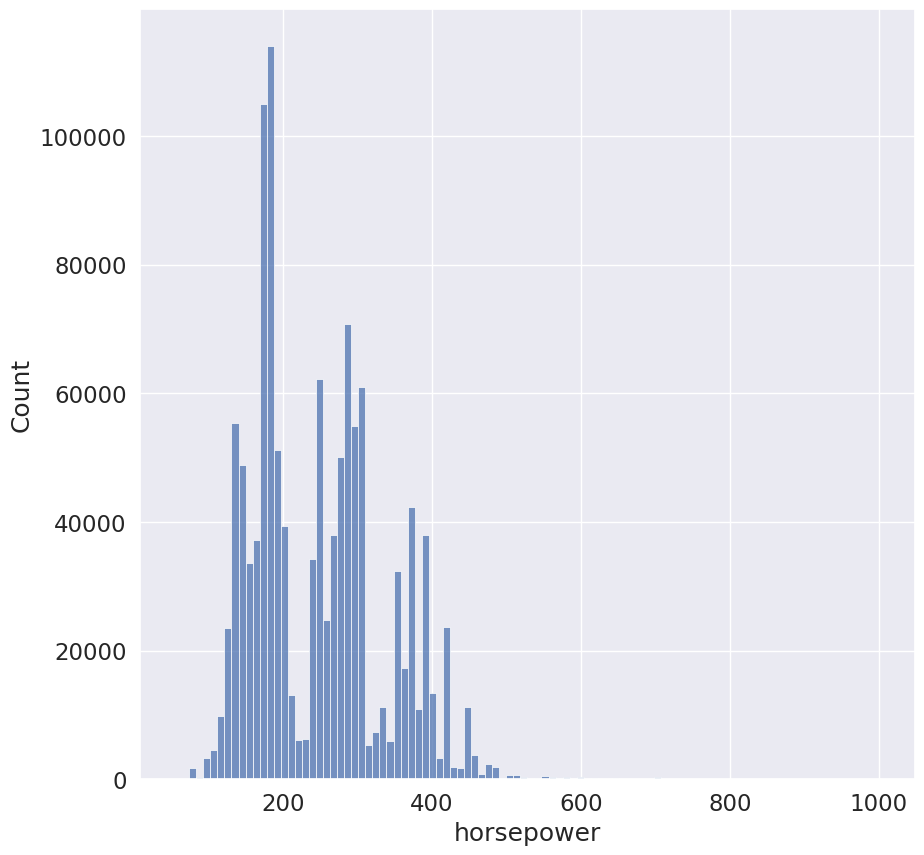

In [22]:
fig, ax = plt.subplots()
sns.histplot(data_rep['horsepower'], bins = 100)
plt.show()

In [23]:
#data_rep = data_rep[train.horsepower <threshold_hp]

In [24]:
rep_columns = ['make_name', 'model_name', 'year', 'trim_name', 'highway_fuel_economy']
hp_target = data_rep.horsepower
ed_target = data_rep.engine_displacement
rep_data = data_rep[rep_columns]

In [25]:
train_pool = Pool(rep_data,
                  hp_target,
                  cat_features=[0,1,3])
model_hp = CatBoostRegressor(iterations=150,
                          depth=5,
                          learning_rate=0.3,
                          loss_function='RMSE')

In [26]:
model_hp.fit(train_pool)

0:	learn: 71.0039301	total: 412ms	remaining: 1m 1s
1:	learn: 59.3617816	total: 652ms	remaining: 48.2s
2:	learn: 52.1510124	total: 851ms	remaining: 41.7s
3:	learn: 47.6221620	total: 1.03s	remaining: 37.8s
4:	learn: 45.0328073	total: 1.23s	remaining: 35.8s
5:	learn: 41.9956883	total: 1.43s	remaining: 34.3s
6:	learn: 40.3040429	total: 1.63s	remaining: 33.4s
7:	learn: 38.9580922	total: 1.99s	remaining: 35.3s
8:	learn: 38.3102903	total: 2.29s	remaining: 35.8s
9:	learn: 37.8741797	total: 2.58s	remaining: 36.1s
10:	learn: 37.2335671	total: 2.9s	remaining: 36.6s
11:	learn: 36.8385748	total: 3.21s	remaining: 37s
12:	learn: 36.4819944	total: 3.51s	remaining: 37s
13:	learn: 35.9568673	total: 3.83s	remaining: 37.2s
14:	learn: 35.7048029	total: 4.13s	remaining: 37.2s
15:	learn: 35.4265644	total: 4.43s	remaining: 37.1s
16:	learn: 35.2160576	total: 4.72s	remaining: 36.9s
17:	learn: 35.0597950	total: 4.9s	remaining: 35.9s
18:	learn: 34.7575750	total: 5.08s	remaining: 35s
19:	learn: 34.5995714	total: 5

In [27]:
pred_pool_train = Pool(train[rep_columns],
                 cat_features=[0,1,3])
pred_pool_val = Pool(valid[rep_columns],
                 cat_features=[0,1,3])

In [28]:
train['hp_pred'] = model_hp.predict(pred_pool_train)
valid['hp_pred'] = model_hp.predict(pred_pool_val)

In [29]:
errs = mean_squared_error(valid[valid['horsepower'] > 0].horsepower, valid[valid['horsepower'] > 0].hp_pred, squared = False)
print("RMSE = ", errs)

RMSE =  26.526509257756565


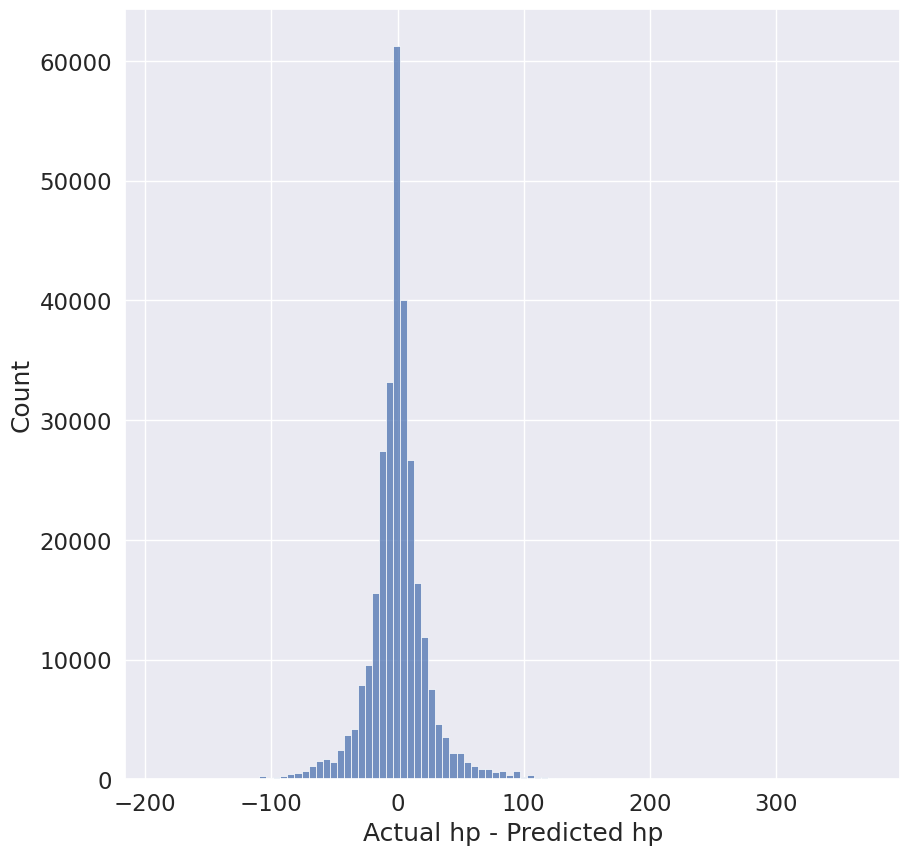

In [30]:
fig, ax = plt.subplots()
sns.histplot(valid.horsepower - valid.hp_pred, bins = 100)
plt.xlabel('Actual hp - Predicted hp')
plt.show()

In [31]:
train['horsepower'] = train.apply(lambda x: x['hp_pred'] if pd.isnull(x['horsepower']) else x['horsepower'], axis=1)
valid['horsepower'] = valid.apply(lambda x: x['hp_pred'] if pd.isnull(x['horsepower']) else x['horsepower'], axis=1)

Восстанавливаем объем

In [32]:
data_rep = train[train.engine_displacement > 0]

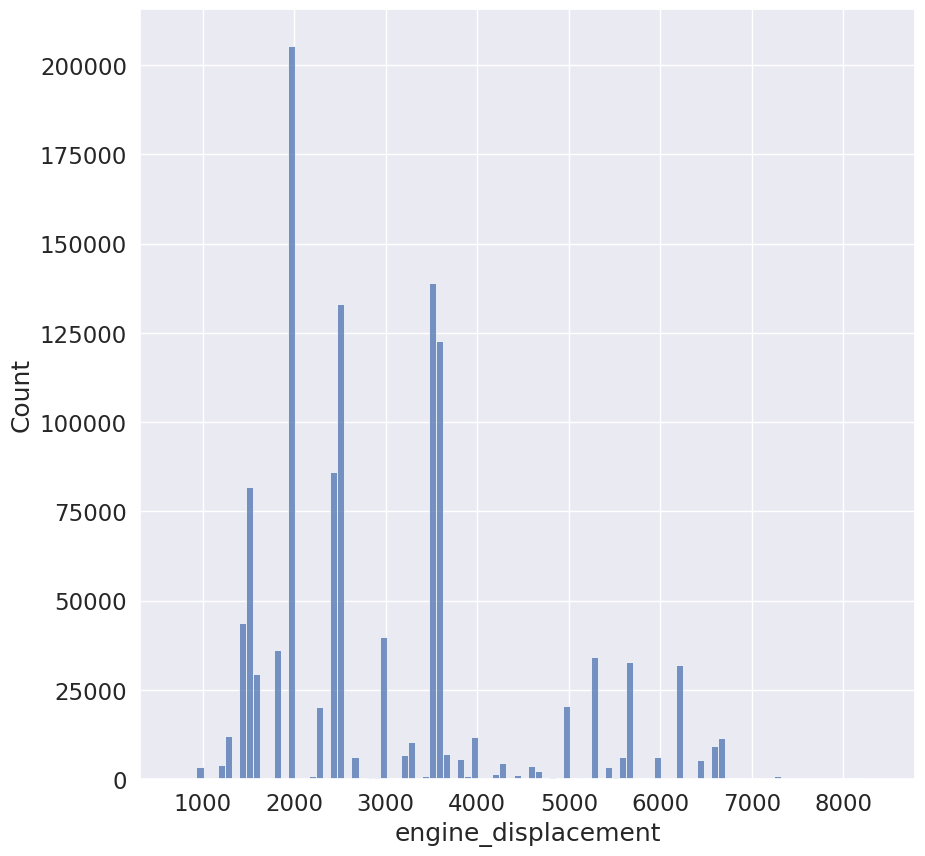

In [33]:
fig, ax = plt.subplots()
sns.histplot(data_rep['engine_displacement'], bins = 100)
plt.show()

In [34]:
quartiles = np.percentile(data_rep.engine_displacement, [25, 50, 75])
mu, sig = quartiles[1], 0.74 * (quartiles[2] - quartiles[0])
threshold_ed = mu + 3*sig + 1000
threshold_ed

7052.0

In [35]:
(data_rep.engine_displacement.count() - data_rep[data_rep['engine_displacement'] < threshold_ed].engine_displacement.count()) / data_rep.engine_displacement.count() * 100

0.11787964513437692

In [36]:
#data_rep = data_rep[data_rep.engine_displacement < threshold_ed]

In [37]:
train_pool = Pool(rep_data,
                  ed_target,
                  cat_features=[0,1,3])
model_ed = CatBoostRegressor(iterations=150,
                          depth=5,
                          learning_rate=0.3,
                          loss_function='RMSE')

In [38]:
model_ed.fit(train_pool)

0:	learn: 1081.3873142	total: 305ms	remaining: 45.5s
1:	learn: 893.2752029	total: 487ms	remaining: 36s
2:	learn: 782.5921714	total: 670ms	remaining: 32.9s
3:	learn: 707.5804149	total: 859ms	remaining: 31.4s
4:	learn: 664.7774056	total: 1.04s	remaining: 30.1s
5:	learn: 618.4941981	total: 1.24s	remaining: 29.8s
6:	learn: 588.9526534	total: 1.43s	remaining: 29.2s
7:	learn: 569.9266689	total: 1.61s	remaining: 28.7s
8:	learn: 557.3198008	total: 1.8s	remaining: 28.1s
9:	learn: 546.8106291	total: 1.99s	remaining: 27.8s
10:	learn: 537.2823194	total: 2.17s	remaining: 27.4s
11:	learn: 529.0150860	total: 2.34s	remaining: 26.9s
12:	learn: 524.8979257	total: 2.51s	remaining: 26.5s
13:	learn: 520.2341249	total: 2.7s	remaining: 26.2s
14:	learn: 515.2501931	total: 2.87s	remaining: 25.9s
15:	learn: 512.3749209	total: 3.06s	remaining: 25.6s
16:	learn: 509.7466253	total: 3.23s	remaining: 25.3s
17:	learn: 506.3086336	total: 3.41s	remaining: 25s
18:	learn: 504.7597922	total: 3.6s	remaining: 24.8s
19:	learn

In [39]:
train['ed_pred'] = model_ed.predict(pred_pool_train)
valid['ed_pred'] = model_ed.predict(pred_pool_val)

In [40]:
errs = mean_squared_error(valid[valid['engine_displacement'] > 0].engine_displacement, valid[valid['engine_displacement'] > 0].ed_pred, squared = False)
print("RMSE = ", errs)

RMSE =  381.7213472469359


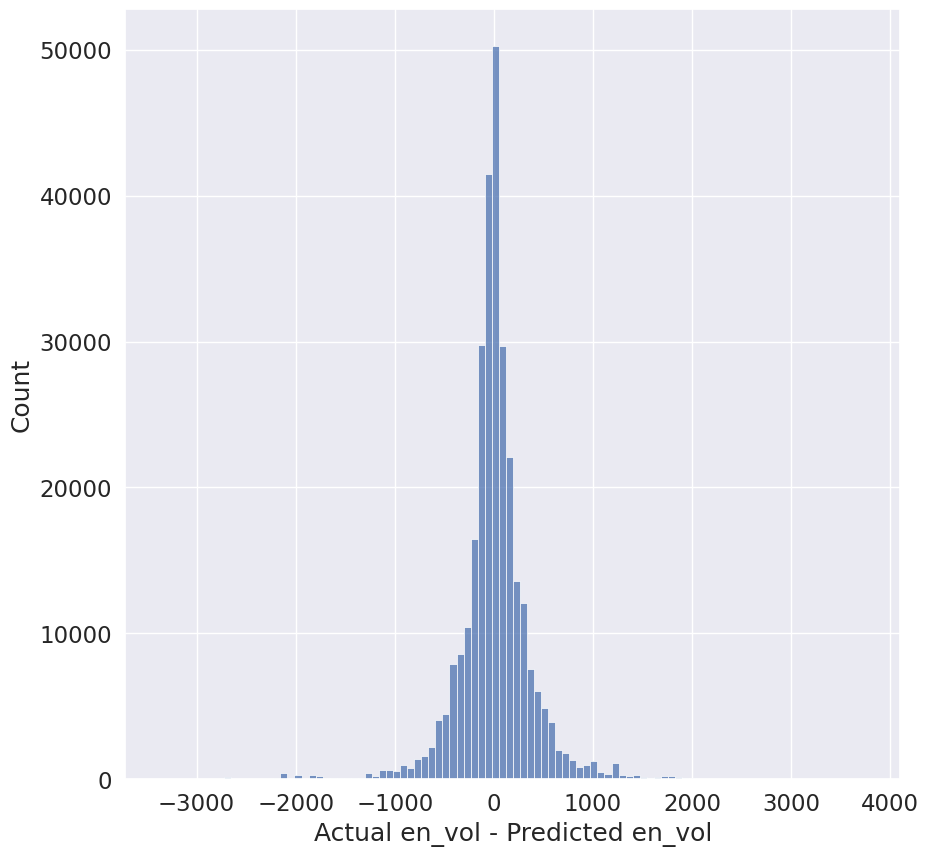

In [41]:
fig, ax = plt.subplots()
sns.histplot(valid.engine_displacement - valid.ed_pred, bins = 100)
plt.xlabel('Actual en_vol - Predicted en_vol')
plt.show()

In [42]:
train['engine_displacement'] = train.apply(lambda x: x['ed_pred'] if pd.isnull(x['engine_displacement']) else x['engine_displacement'], axis=1)
valid['engine_displacement'] = valid.apply(lambda x: x['ed_pred'] if pd.isnull(x['engine_displacement']) else x['engine_displacement'], axis=1)

# Убираем выбросы

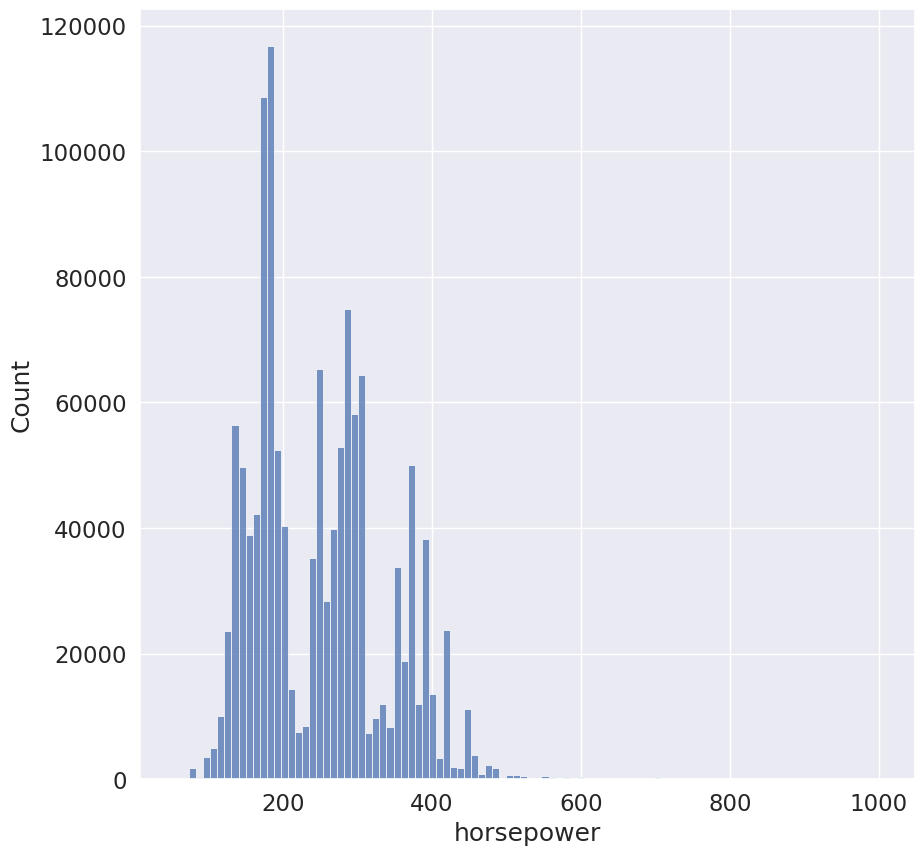

In [43]:
fig, ax = plt.subplots()
sns.histplot(train['horsepower'], bins = 100)
plt.show()

In [44]:
quartiles_hp = np.percentile(train.horsepower, [25, 50, 75])
mu_hp, sig_hp = quartiles_hp[1], 0.74 * (quartiles_hp[2] - quartiles_hp[0])
threshold_hp = mu_hp + 3*sig_hp + 150
mu_hp, sig_hp, threshold_hp

(245.0, 95.46, 681.38)

In [45]:
(train.horsepower.count() - train[train['horsepower'] < threshold_hp].horsepower.count()) / train.horsepower.count() * 100

0.06072064692491594

In [46]:
train = train[train.horsepower > 0]
train = train[train.horsepower < threshold_hp]

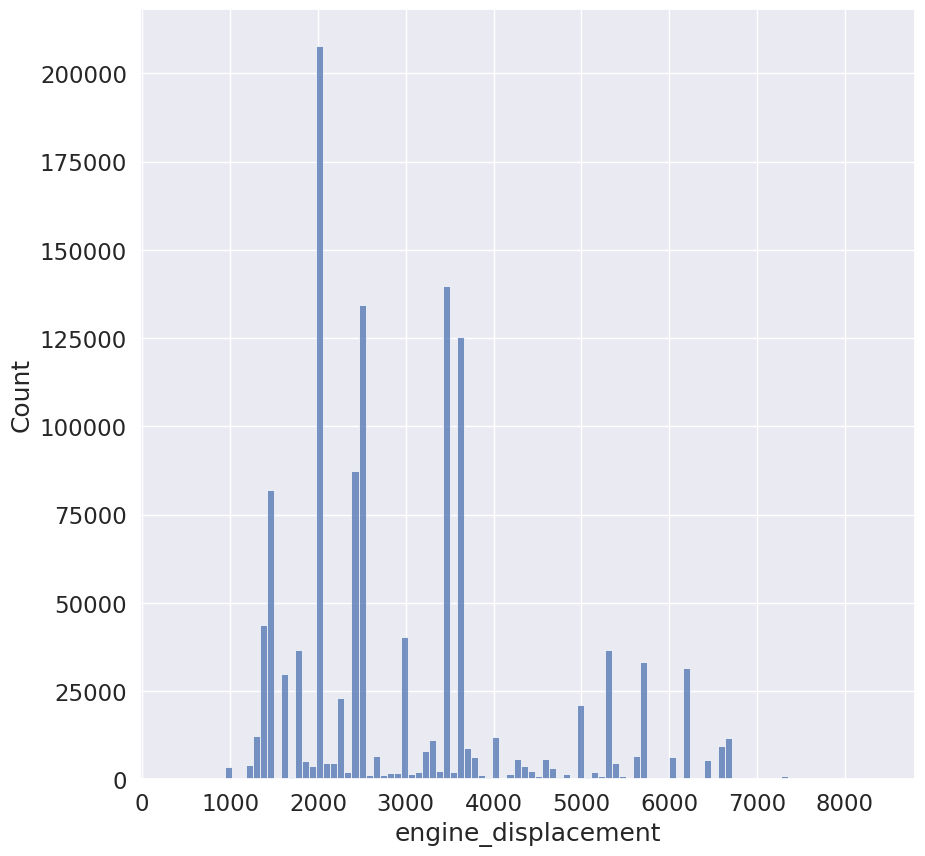

In [47]:
fig, ax = plt.subplots()
sns.histplot(train['engine_displacement'], bins = 100)
plt.show()

In [48]:
quartiles_ed = np.percentile(train.engine_displacement, [25, 50, 75])
mu_ed, sig_ed = quartiles_ed[1], 0.74 * (quartiles_ed[2] - quartiles_ed[0])
threshold_ed = mu_ed + 3*sig_ed + 1000
threshold_ed

7052.0

In [49]:
(train.engine_displacement.count() - train[train['engine_displacement'] < threshold_ed].engine_displacement.count()) / train.engine_displacement.count() * 100

0.11134911123236145

In [50]:
train = train[train.engine_displacement > 0]
train = train[train.engine_displacement < threshold_ed]

In [51]:
train['pow_per_vol'] = round(train['horsepower'] / train['engine_displacement'], 3)
valid['pow_per_vol'] = round(valid['horsepower'] / valid['engine_displacement'], 3)

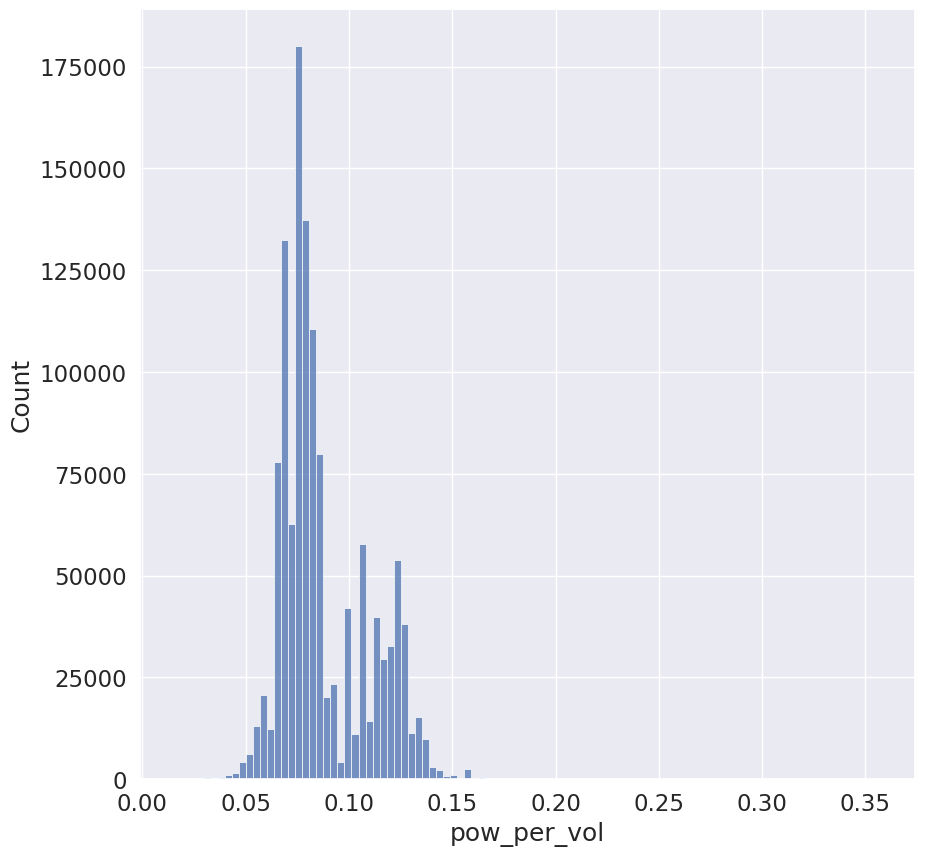

In [52]:
fig, ax = plt.subplots()
sns.histplot(train['pow_per_vol'], bins = 100)
plt.show()

In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1257701 entries, 0 to 1259867
Data columns (total 15 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   vin                   1257701 non-null  object 
 1   engine_displacement   1257701 non-null  float64
 2   has_accidents         1257701 non-null  object 
 3   highway_fuel_economy  1257701 non-null  float64
 4   horsepower            1257701 non-null  float64
 5   isCab                 1257701 non-null  object 
 6   make_name             1257701 non-null  object 
 7   mileage               1195771 non-null  float64
 8   model_name            1257701 non-null  object 
 9   price                 1257701 non-null  float64
 10  trim_name             1257701 non-null  object 
 11  year                  1257701 non-null  int64  
 12  hp_pred               1257701 non-null  float64
 13  ed_pred               1257701 non-null  float64
 14  pow_per_vol           1257701 non-

In [54]:
df_corr = train.corr()

<Axes: >

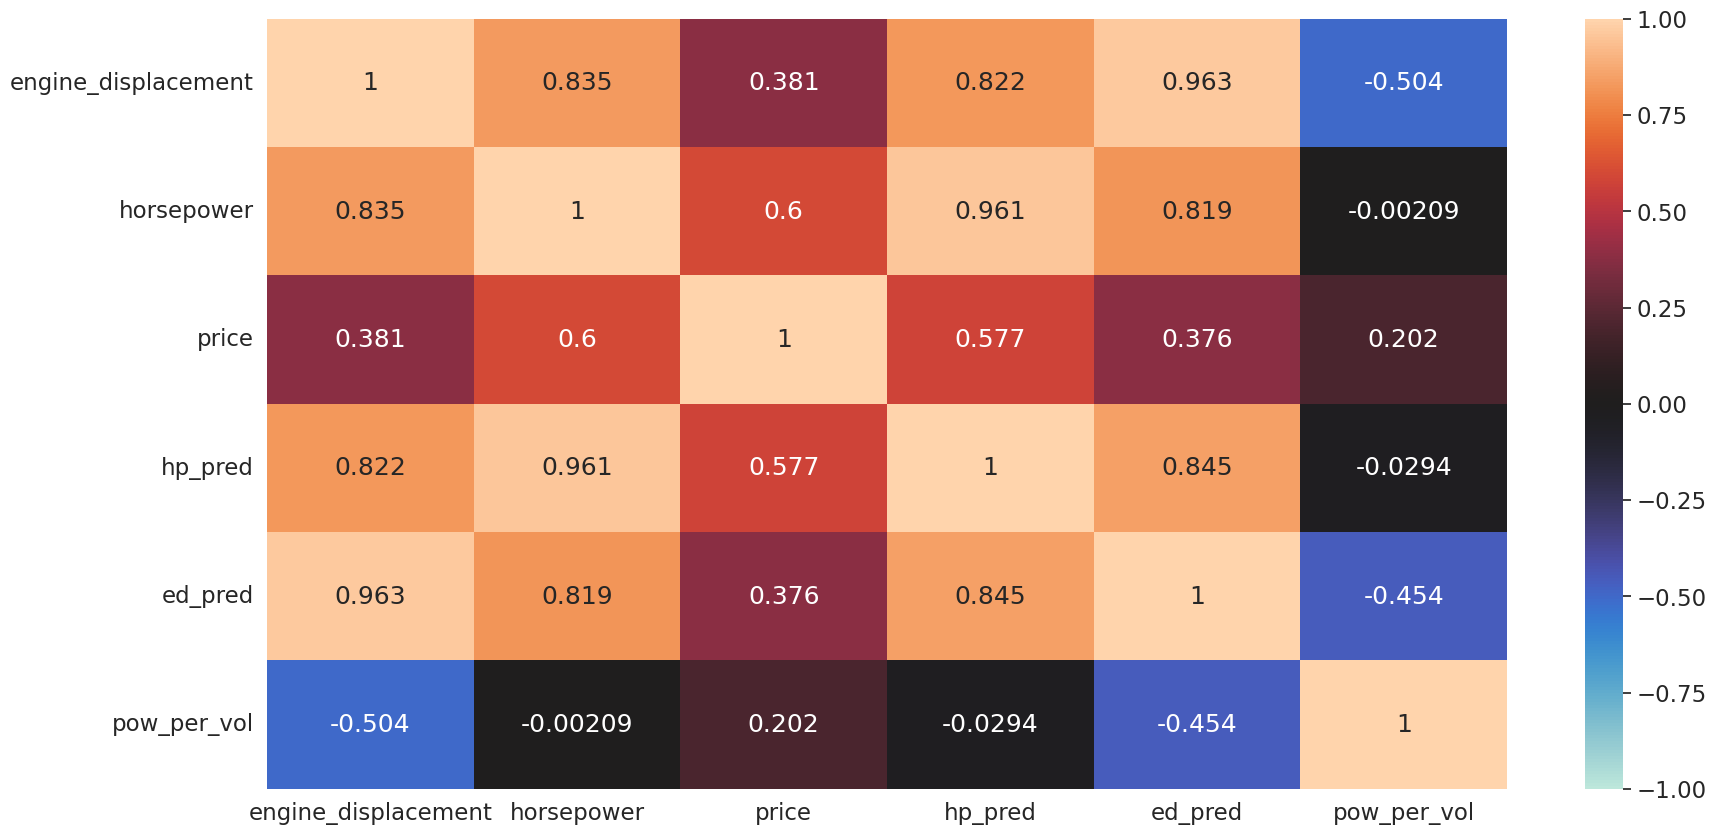

In [55]:
sns.set(
    rc = {  # параметры графика
        'figure.figsize': (20, 10),  # (ширина, высота)
    },
    font_scale=1.5,  # размер шрифта
)
mask = df_corr.price > 0.1
sns.heatmap(
    df_corr.loc[mask,mask],  # датасет
    annot=True,  # вывод значений в ячейках
    fmt='.3g',  # формат значений
    vmin=-1,  # нижнее значение цветовой гаммы
    vmax=1,  # верхнее значение цветовой гаммы
    center=0,  # среднее значение цветовой гаммы
)

In [56]:
(train.pow_per_vol.count() - train[train['pow_per_vol'] < 0.20].pow_per_vol.count()) / train.pow_per_vol.count() * 100

0.058678493537017144

In [57]:
train = train[train.pow_per_vol < 0.20]

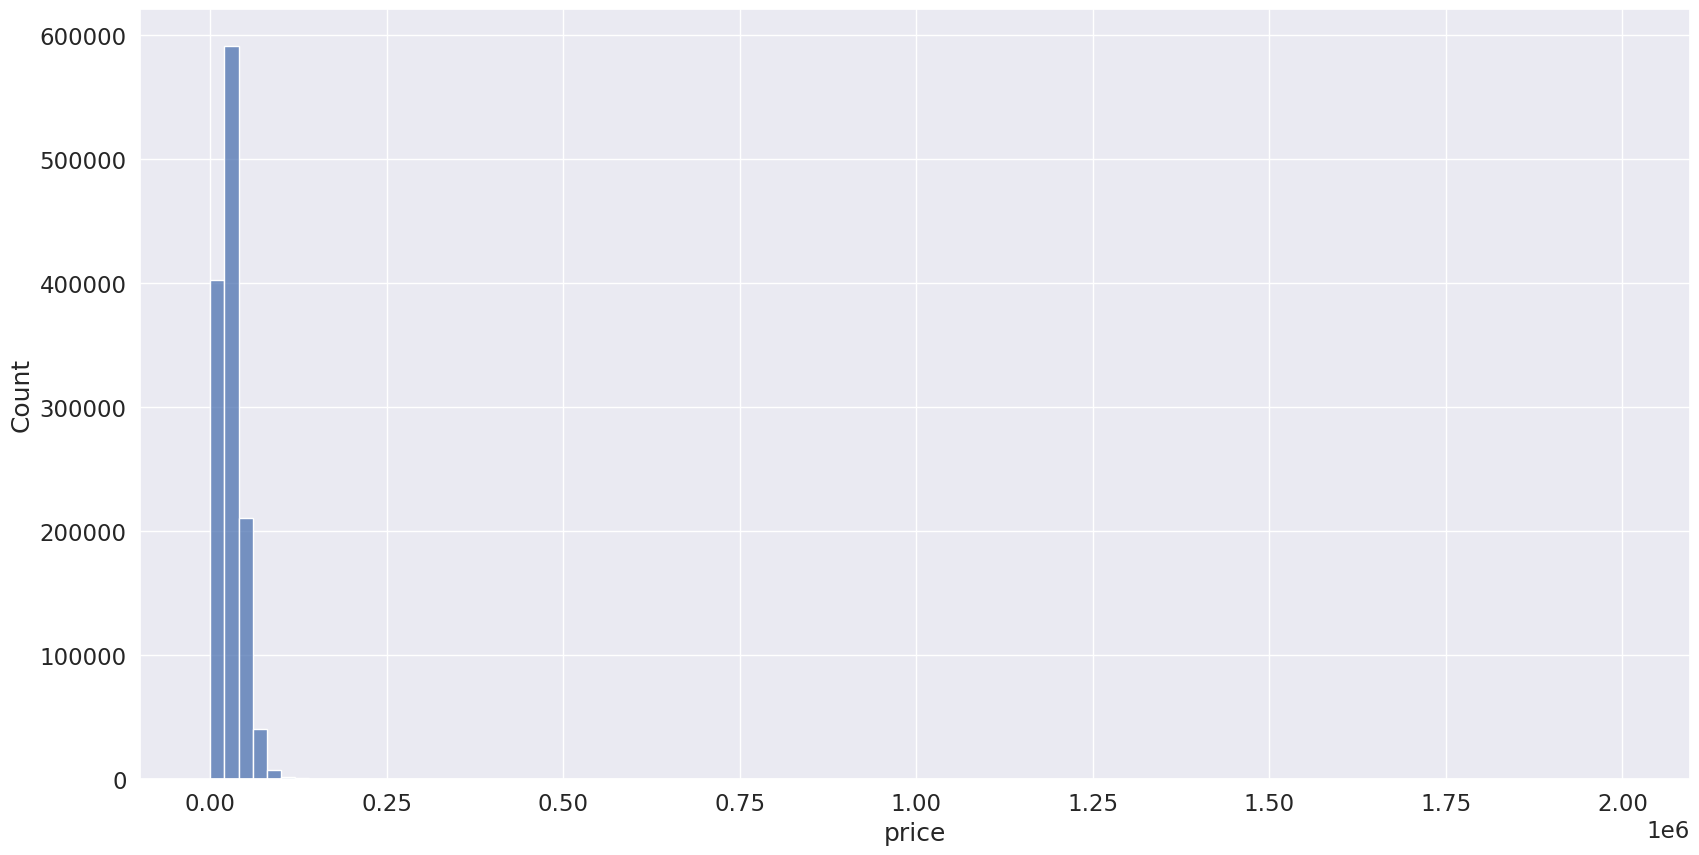

In [58]:
fig, ax = plt.subplots()
sns.histplot(train['price'], bins = 100)
plt.show()

In [59]:
(train.price.count() - train[train['price'] < 1000000].price.count()) / train.price.count() * 100

0.0005568978561819242

In [60]:
train = train[train.price < 1500000]

# Обучаем, смотрим результат на валидационной выборке

In [61]:
columns = ['has_accidents', 'isCab', 'trim_name', 'make_name', 'model_name', 'year', 'horsepower', 'pow_per_vol']
target = train.price

In [62]:
df = train[columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1256962 entries, 0 to 1259867
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   has_accidents  1256962 non-null  object 
 1   isCab          1256962 non-null  object 
 2   trim_name      1256962 non-null  object 
 3   make_name      1256962 non-null  object 
 4   model_name     1256962 non-null  object 
 5   year           1256962 non-null  int64  
 6   horsepower     1256962 non-null  float64
 7   pow_per_vol    1256962 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 86.3+ MB


In [63]:
train_pool = Pool(df,
                  target,
                  cat_features=[0,1,2,3,4])
test_pool = Pool(valid[columns],
                 cat_features=[0,1,2,3,4])

model_prod = CatBoostRegressor(iterations=500,
                               depth=5,
                               learning_rate=0.3,
                               random_seed = 42)

In [ ]:
model_prod.fit(train_pool)
y_pred = model_prod.predict(test_pool)

In [77]:
dict(zip(columns, model_prod.feature_importances_.tolist()))

{'has_accidents': 0.4201953592721135,
 'isCab': 3.491636607739531,
 'trim_name': 5.532072938971554,
 'make_name': 9.460652693287054,
 'model_name': 22.20399585549313,
 'year': 27.059479168623515,
 'horsepower': 26.920337626451797,
 'pow_per_vol': 4.9116297501613175}

In [66]:
rmse = mean_squared_error(valid.price, y_pred, squared = False)
print("RMSE = ", rmse)

RMSE =  7508.349754217141


In [67]:
mape = mean_absolute_percentage_error(valid.price, y_pred)
print("MAPE = ", mape)

MAPE =  0.11616520556224122


In [68]:
df_test = pd.read_csv('/content/drive/MyDrive/test.csv', usecols=['has_accidents', 'isCab', 'trim_name', 'make_name', 'model_name', 'year', 'horsepower', 'engine_displacement', 'highway_fuel_economy', 'vin', 'mileage'])

KeyboardInterrupt: ignored

In [ ]:
m_n = df_test['make_name'].unique()
for el in m_n:
    if el not in trim_med_values:
        perc_Na = round(100 *(df_test.loc[df_test['make_name'] == el].trim_name.isna().sum() / df_test[df_test['make_name'] == el].shape[0]), 2)
        if perc_Na == 100:
            print('% = 100, value = ', 'Unknown')
            trim_med_values[el] = 'Unknown'
        else:
            print('% < 100, VALUE for class = ', df_test.loc[df_test['make_name'] == el].trim_name.mode()[0])
            trim_med_values[el] = df_test.loc[df_test['make_name'] == el].trim_name.mode()[0]

In [ ]:
df_test['trim_name'] = df_test.apply(lambda x: trim_med_values[x['make_name']] if pd.isnull(x['trim_name']) else x['trim_name'], axis=1)
df_test['trim_name']

In [ ]:
df_test.year = df_test['year'].apply(lambda x: datetime.now().year - x)

In [ ]:
df_test['has_accidents'].fillna(value = 'Unknown', inplace = True)
df_test['isCab'].fillna(value = 'Unknown', inplace = True)
df_test['highway_fuel_economy'].fillna(value = hfe_val, inplace = True)

In [ ]:
pred_pool_t = Pool(df_test[rep_columns],
                 cat_features=[0,1,3])

In [ ]:
df_test['ed_pred'] = model_ed.predict(pred_pool_t)
df_test['hp_pred'] = model_hp.predict(pred_pool_t)

In [ ]:
df_test['engine_displacement'] = df_test.apply(lambda x: x['ed_pred'] if pd.isnull(x['engine_displacement']) else x['engine_displacement'], axis=1)
df_test['horsepower'] = df_test.apply(lambda x: x['hp_pred'] if pd.isnull(x['horsepower']) else x['horsepower'], axis=1)

In [ ]:
df_test['pow_per_vol'] = round(df_test['horsepower'] / df_test['engine_displacement'], 3)

In [ ]:
test = df_test[columns]
tp = Pool(test, cat_features=[0,1,2,3,4])
df_test['price'] = model_prod.predict(tp)

In [ ]:
df_test[['vin','price']].to_csv('submission.csv', index=False)